In [1]:
path = ' /content/drive/MyDrive/Copy of aruba.20100217-20240201_20240625.181859.txt'

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import random

In [3]:
# Load and preprocess data
def load_data(file_path, num_rows=20000):
    data = pd.read_csv(file_path, sep='\s+', header=None,
                       names=['Date', 'Time', 'Sensor', 'State'])
    data = data.iloc[:num_rows,:]
    data['DateTime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'], format='%Y-%m-%d %H:%M:%S.%f')
    return data

In [4]:
# Function to create sequences
def create_sequences(df, sequence_length=60):
    sequences = []
    labels = []
    for i in range(len(df) - sequence_length):
        sequence = df.iloc[i:i+sequence_length].drop(columns=['Label']).values
        label = df['Label'].iloc[i+sequence_length-1]
        sequences.append(sequence)
        labels.append(label)
    return np.array(sequences), np.array(labels)

In [5]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load normal data (after mounting)
normal_data = load_data(file_path='/content/drive/MyDrive/Copy of aruba.20100217-20240201_20240625.181859.txt') # Make sure this path is correct
normal_data['Label'] = 0

Mounted at /content/drive


In [6]:
normal_data

,Date,Time,Sensor,State,DateTime,Label
0,2010-10-13,16:53:58.648634,M022,OFF,2010-10-13 16:53:58.648634,0
1,2010-10-13,16:53:58.674960,M030,OFF,2010-10-13 16:53:58.674960,0
2,2010-10-13,16:53:58.701451,M001,OFF,2010-10-13 16:53:58.701451,0
3,2010-10-13,16:53:58.731156,D001,CLOSE,2010-10-13 16:53:58.731156,0
4,2010-10-13,16:53:58.756695,D004,CLOSE,2010-10-13 16:53:58.756695,0
...,...,...,...,...,...,...
19995,2010-10-14,18:58:28.179230,M019,ON,2010-10-14 18:58:28.179230,0
19996,2010-10-14,18:58:30.651351,M019,OFF,2010-10-14 18:58:30.651351,0
19997,2010-10-14,18:58:31.275414,M019,ON,2010-10-14 18:58:31.275414,0
19998,2010-10-14,18:58:39.126688,M019,OFF,2010-10-14 18:58:39.126688,0


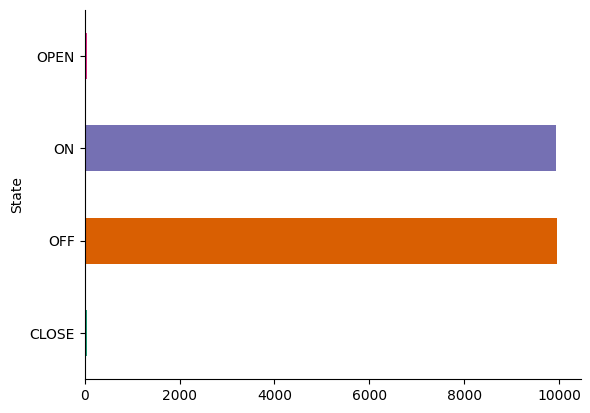

In [7]:
# @title State

from matplotlib import pyplot as plt
import seaborn as sns
normal_data.groupby('State').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [8]:
# Calculate action frequency
def calculate_action_frequency(df, sensor, time_window='10min'):
    filtered_df = df[df['Sensor'] == sensor]
    filtered_df = filtered_df[filtered_df['State'] == 'ON']
    return filtered_df.groupby(pd.Grouper(key='DateTime', freq=time_window)).size()


In [9]:

normal_frequencies = {}
for sensor in normal_data['Sensor'].unique():
    normal_frequencies[sensor] = calculate_action_frequency(normal_data, sensor, time_window='1min')


In [10]:

# Simulate Alzheimer's-like behavior changes
alzheimer_data = []
for i in range(len(normal_data)):
    timestamp = normal_data['DateTime'][i]
    sensor = normal_data['Sensor'][i]
    state = normal_data['State'][i]

    if sensor in ['M015', 'M019', 'M014', 'M024', 'M007', 'M027']: # Example sensors for repetitive behavior
        frequency_factor = np.random.normal(loc=1.5, scale=0.5)
        if state == 'ON':
            if random.random() < frequency_factor:
                alzheimer_data.append([timestamp, sensor, state])
        else:
            alzheimer_data.append([timestamp, sensor, state])
    elif sensor in ['M017', 'M018', 'M021']: # Example sensors for reduced activity
        frequency_factor = np.random.normal(loc=0.5, scale=0.2)
        if state == 'ON':
            if random.random() < frequency_factor:
                alzheimer_data.append([timestamp, sensor, state])
        else:
            alzheimer_data.append([timestamp, sensor, state])
    else:
        alzheimer_data.append([timestamp, sensor, state])

# Convert alzheimer_data to DataFrame
alzheimer_df = pd.DataFrame(alzheimer_data, columns=['DateTime', 'Sensor', 'State'])
alzheimer_df['Label'] = 1

In [11]:
# Simulate Alzheimer's-like behavior changes
alzheimer_data = []
for i in range(len(normal_data)):
    timestamp = normal_data['DateTime'][i]
    sensor = normal_data['Sensor'][i]
    state = normal_data['State'][i]

    if sensor in ['M015', 'M019', 'M014', 'M024', 'M007', 'M027']: # Example sensors for repetitive behavior
        frequency_factor = np.random.normal(loc=1.5, scale=0.5)
        if state == 'ON':
            if random.random() < frequency_factor:
                alzheimer_data.append([timestamp, sensor, state])
        else:
            alzheimer_data.append([timestamp, sensor, state])
    elif sensor in ['M017', 'M018', 'M021']: # Example sensors for reduced activity
        frequency_factor = np.random.normal(loc=0.5, scale=0.2)
        if state == 'ON':
            if random.random() < frequency_factor:
                alzheimer_data.append([timestamp, sensor, state])
        else:
            alzheimer_data.append([timestamp, sensor, state])
    else:
        alzheimer_data.append([timestamp, sensor, state])

# Convert alzheimer_data to DataFrame
alzheimer_df = pd.DataFrame(alzheimer_data, columns=['DateTime', 'Sensor', 'State'])
alzheimer_df['Label'] = 1

In [12]:
# Combine and preprocess data
combined_data = pd.concat([normal_data, alzheimer_df], ignore_index=True)
combined_data = pd.get_dummies(combined_data, columns=['Sensor', 'State'])

In [13]:
# Map labels to integers
label_mapping = {1: 1, 0: 0}
combined_data['Label'] = combined_data['Label'].map(label_mapping)

In [14]:
combined_data.head()

,Date,Time,DateTime,Label,Sensor_D001,Sensor_D002,Sensor_D004,Sensor_M001,Sensor_M002,Sensor_M003,...,Sensor_M026,Sensor_M027,Sensor_M028,Sensor_M029,Sensor_M030,Sensor_M031,State_CLOSE,State_OFF,State_ON,State_OPEN
0,2010-10-13,16:53:58.648634,2010-10-13 16:53:58.648634,0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
1,2010-10-13,16:53:58.674960,2010-10-13 16:53:58.674960,0,False,False,False,False,False,False,...,False,False,False,False,True,False,False,True,False,False
2,2010-10-13,16:53:58.701451,2010-10-13 16:53:58.701451,0,False,False,False,True,False,False,...,False,False,False,False,False,False,False,True,False,False
3,2010-10-13,16:53:58.731156,2010-10-13 16:53:58.731156,0,True,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
4,2010-10-13,16:53:58.756695,2010-10-13 16:53:58.756695,0,False,False,True,False,False,False,...,False,False,False,False,False,False,True,False,False,False


In [15]:
combined_data = combined_data.drop(columns=['DateTime','Time','Date'])


In [16]:
# Create sequences
X, y = create_sequences(combined_data)

In [17]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [18]:
 y_train.dtype, y_test.dtype

(dtype('int64'), dtype('int64'))

In [19]:
 X_train.shape, X_test.shape

((31212, 60, 38), (7804, 60, 38))

In [20]:
# Convert data types
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
y_train = y_train.astype('int')
y_test = y_test.astype('int')

In [21]:
X_train[1]

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [22]:

# Check for NaN values and handle them
X_train_df = pd.DataFrame(X_train.reshape(X_train.shape[0], -1))
X_test_df = pd.DataFrame(X_test.reshape(X_test.shape[0], -1))

X_train_df.fillna(X_train_df.mean(), inplace=True)
X_test_df.fillna(X_test_df.mean(), inplace=True)

X_train = X_train_df.values.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test_df.values.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])


###GRU Model

In [23]:
from keras.models import Sequential
from keras.layers import GRU, Dense

model1 = Sequential([
    GRU(100, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    GRU(50, activation='tanh'),  # Another GRU layer (optional)
    Dense(1, activation='sigmoid')
])


# Compile the model (you can adjust optimizer and learning rate)
optimizer = Adam(learning_rate=0.001, clipnorm=1.0)
model1.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history1 = model1.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.6292 - loss: 0.6112 - val_accuracy: 0.6947 - val_loss: 0.5252
Epoch 2/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accuracy: 0.7859 - loss: 0.4204 - val_accuracy: 0.8228 - val_loss: 0.3610
Epoch 3/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.8303 - loss: 0.3488 - val_accuracy: 0.8493 - val_loss: 0.3275
Epoch 4/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.8521 - loss: 0.2953 - val_accuracy: 0.8646 - val_loss: 0.2668
Epoch 5/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.8597 - loss: 0.2779 - val_accuracy: 0.8654 - val_loss: 0.2589
Epoch 6/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.8634 - loss: 0.2641 - val_accuracy: 0.8341 - val_loss: 0.3876
Epoch 7/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8668 - loss: 0.2641 - val_accuracy: 0.8743 - val_loss: 0.2248
Epoch 8/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.8760 - loss: 0.2369 - val

In [24]:
# Evaluate the model
loss, accuracy = model1.evaluate(X_test, y_test, verbose=1)
print(f'Test Accuracy: {accuracy:.4f}')

# Make predictions
y_pred = model1.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

# Print results
print(f'Predicted Labels: {y_pred_binary.flatten()}')
print(f'True Labels: {y_test}')

244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9010 - loss: 0.1513
Test Accuracy: 0.9006
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Predicted Labels: [0 0 1 ... 0 0 1]
True Labels: [1 0 1 ... 1 1 1]


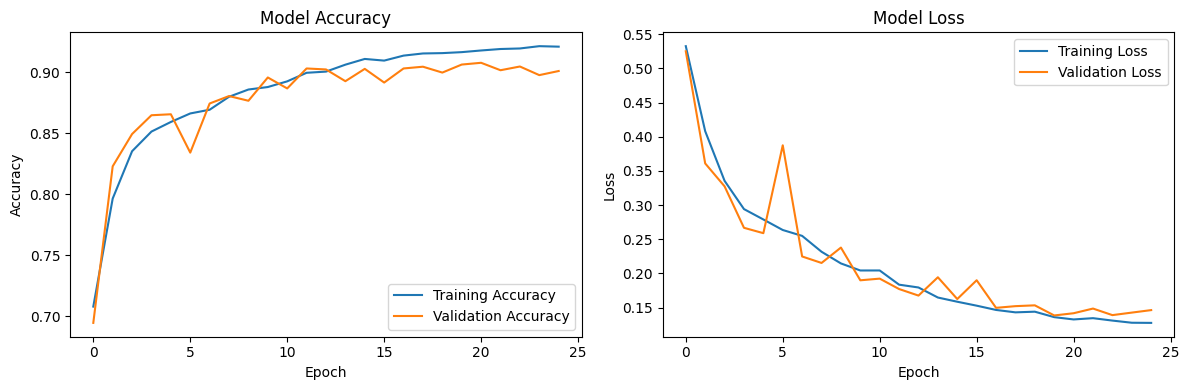

In [25]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history1.history['accuracy'], label='Training Accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history1.history['loss'], label='Training Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Confusion Matrix:
 [[3740  263]
 [ 513 3288]]

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.93      0.91      4003
           1       0.93      0.87      0.89      3801

    accuracy                           0.90      7804
   macro avg       0.90      0.90      0.90      7804
weighted avg       0.90      0.90      0.90      7804


ROC AUC Score: 0.98095538448768


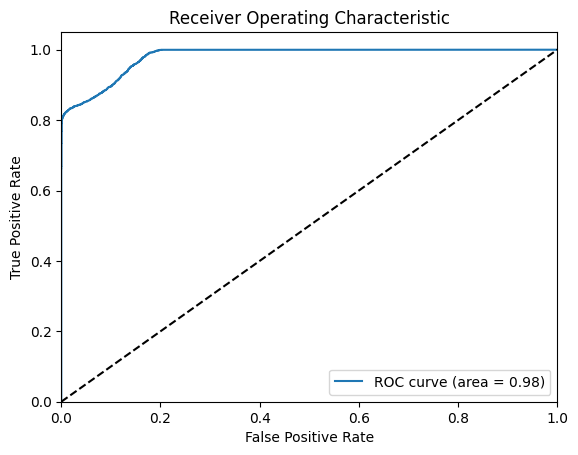

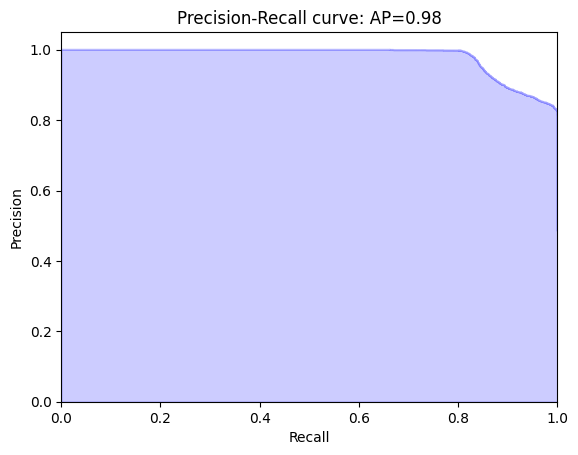

In [27]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report,roc_auc_score, roc_curve, precision_recall_curve, average_precision_score

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_binary)
print("Confusion Matrix:\n", cm)

# Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred_binary))

# ROC AUC Score
roc_auc = roc_auc_score(y_test, y_pred)
print("\nROC AUC Score:", roc_auc)

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred)
average_precision = average_precision_score(y_test, y_pred)
plt.figure()
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
plt.show()


###LSTM Model

In [28]:

# Build the LSTM model
model2 = Sequential([
    LSTM(100, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(50, activation='tanh'),
    Dense(1, activation='sigmoid')
])

# Compile the model
optimizer = Adam(learning_rate=0.001, clipnorm=1.0)
model2.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history2 = model2.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.6773 - loss: 0.5675 - val_accuracy: 0.7528 - val_loss: 0.4738
Epoch 2/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.7903 - loss: 0.4276 - val_accuracy: 0.7876 - val_loss: 0.4470
Epoch 3/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.7990 - loss: 0.4304 - val_accuracy: 0.8185 - val_loss: 0.3974
Epoch 4/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.8095 - loss: 0.3984 - val_accuracy: 0.7717 - val_loss: 0.5022
Epoch 5/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.8114 - loss: 0.3828 - val_accuracy: 0.8392 - val_loss: 0.3615
Epoch 6/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.8158 - loss: 0.3695 - val_accuracy: 0.7964 - val_loss: 0.4251
Epoch 7/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8333 - loss: 0.3358 - val_accuracy: 0.8238 - val_loss: 0.3548
Epoch 8/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.8318 - loss: 0.3342 - val_ac

In [29]:
# Evaluate the model
loss, accuracy = model2.evaluate(X_test, y_test, verbose=1)
print(f'Test Accuracy: {accuracy:.4f}')

# Make predictions
y_pred = model2.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

# Print results
print(f'Predicted Labels: {y_pred_binary.flatten()}')
print(f'True Labels: {y_test}')

244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8999 - loss: 0.1567
Test Accuracy: 0.9022
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Predicted Labels: [1 0 1 ... 0 0 1]
True Labels: [1 0 1 ... 1 1 1]


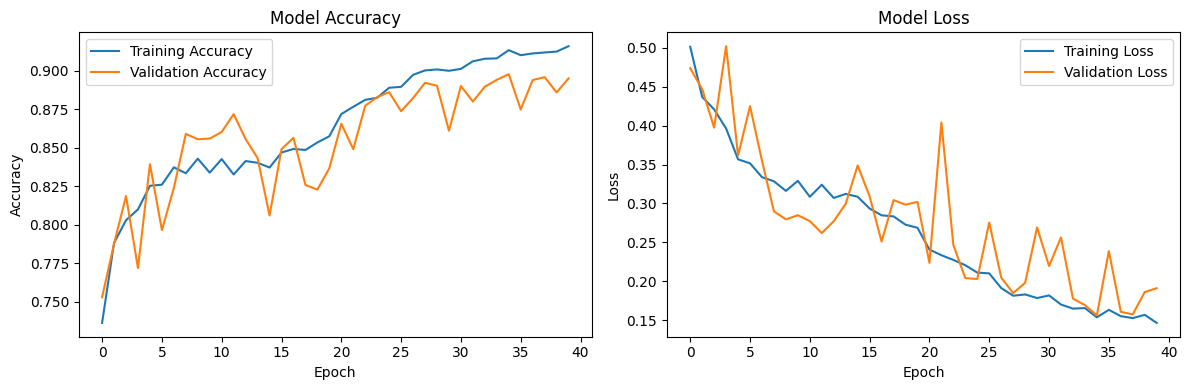

In [30]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'], label='Training Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Confusion Matrix:
 [[3501  502]
 [ 261 3540]]

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.87      0.90      4003
           1       0.88      0.93      0.90      3801

    accuracy                           0.90      7804
   macro avg       0.90      0.90      0.90      7804
weighted avg       0.90      0.90      0.90      7804


ROC AUC Score: 0.9800691444058365


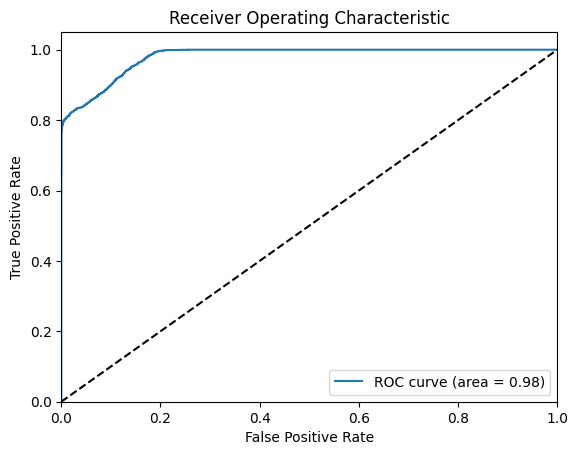

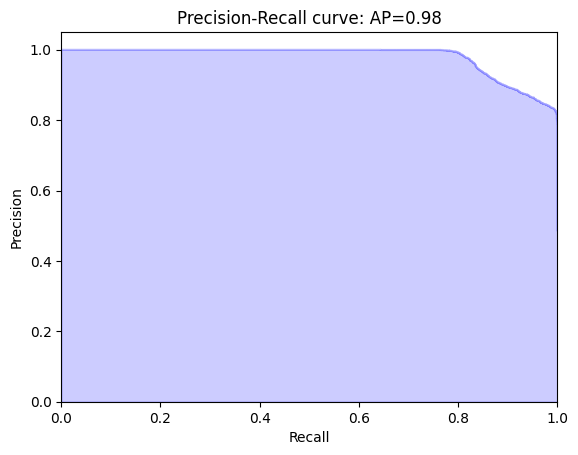

In [31]:

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_binary)
print("Confusion Matrix:\n", cm)

# Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred_binary))

# ROC AUC Score
roc_auc = roc_auc_score(y_test, y_pred)
print("\nROC AUC Score:", roc_auc)

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred)
average_precision = average_precision_score(y_test, y_pred)
plt.figure()
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
plt.show()


### Bidirectional LSTM Model

In [32]:
from tensorflow.keras.layers import Bidirectional, Dropout

# Example: Bidirectional LSTM with Dropout
model3 = Sequential([
    Bidirectional(LSTM(64, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))),
    Dropout(0.3),
    Bidirectional(LSTM(32, activation='tanh')),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [33]:
# Compile the model
optimizer = Adam(learning_rate=0.001, clipnorm=1.0)
model3.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history3 = model3.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - accuracy: 0.6595 - loss: 0.5842 - val_accuracy: 0.8150 - val_loss: 0.3715
Epoch 2/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - accuracy: 0.8001 - loss: 0.3984 - val_accuracy: 0.8300 - val_loss: 0.3349
Epoch 3/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - accuracy: 0.8111 - loss: 0.3764 - val_accuracy: 0.8209 - val_loss: 0.3422
Epoch 4/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - accuracy: 0.8308 - loss: 0.3387 - val_accuracy: 0.8473 - val_loss: 0.2976
Epoch 5/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.8437 - loss: 0.3057 - val_accuracy: 0.8510 - val_loss: 0.2849
Epoch 6/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - accuracy: 0.8620 - loss: 0.2762 - val_accuracy: 0.8679 - val_loss: 0.2594
Epoch 7/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.8706 - loss: 0.2589 - val_accuracy: 0.8773 - val_loss: 0.2290
Epoch 8/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - accuracy: 0.8799 - loss: 0.2443 - 

In [34]:
# Evaluate the model
loss, accuracy = model3.evaluate(X_test, y_test, verbose=1)
print(f'Test Accuracy: {accuracy:.4f}')

# Make predictions
y_pred = model3.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

# Print results
print(f'Predicted Labels: {y_pred_binary.flatten()}')
print(f'True Labels: {y_test}')

244/244 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8978 - loss: 0.1365
Test Accuracy: 0.8997
244/244 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Predicted Labels: [1 0 1 ... 0 0 1]
True Labels: [1 0 1 ... 1 1 1]


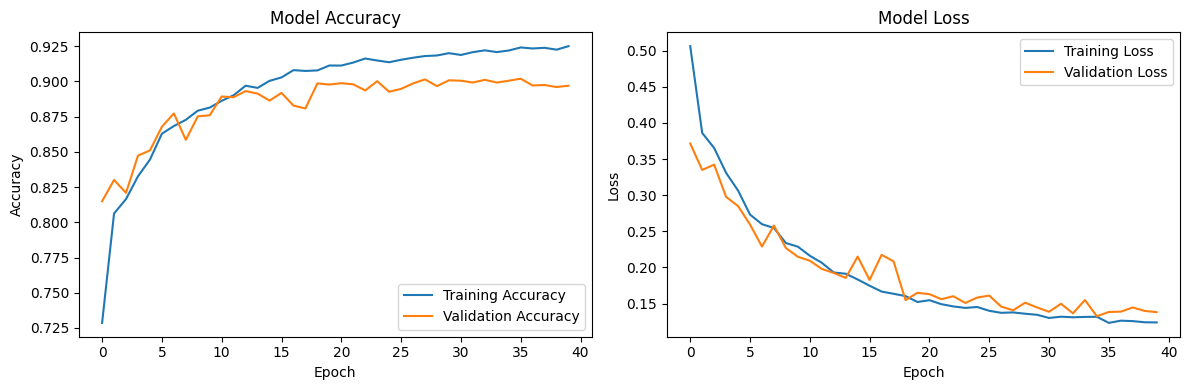

In [35]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history3.history['accuracy'], label='Training Accuracy')
plt.plot(history3.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history3.history['loss'], label='Training Loss')
plt.plot(history3.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Confusion Matrix:
 [[3646  357]
 [ 426 3375]]

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.91      0.90      4003
           1       0.90      0.89      0.90      3801

    accuracy                           0.90      7804
   macro avg       0.90      0.90      0.90      7804
weighted avg       0.90      0.90      0.90      7804


ROC AUC Score: 0.9820136213283343


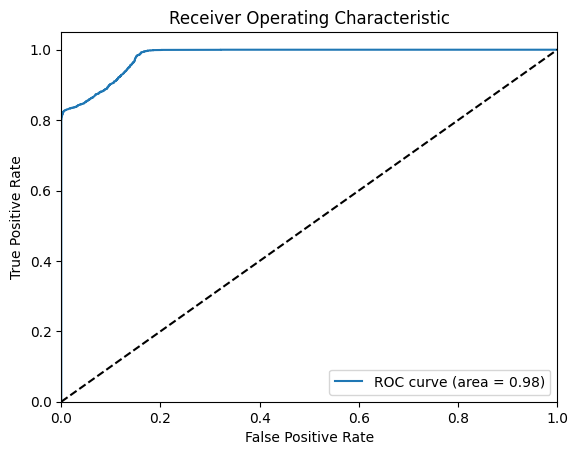

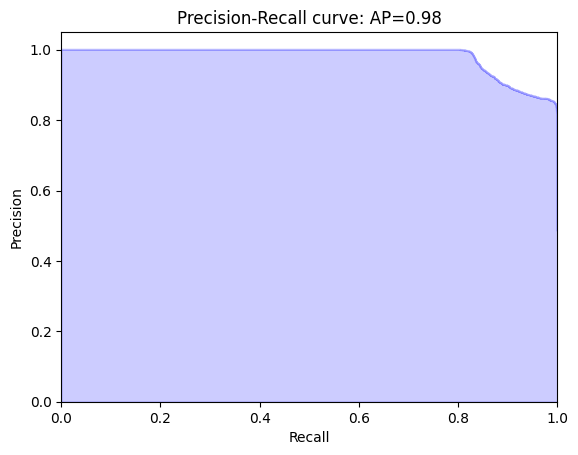

In [36]:

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_binary)
print("Confusion Matrix:\n", cm)

# Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred_binary))

# ROC AUC Score
roc_auc = roc_auc_score(y_test, y_pred)
print("\nROC AUC Score:", roc_auc)

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred)
average_precision = average_precision_score(y_test, y_pred)
plt.figure()
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
plt.show()


###1D Conv Model


In [37]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten
model4 = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='selu', input_shape=(X_train.shape[1], X_train.shape[2])),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=32, kernel_size=3, activation='selu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(1, activation='sigmoid')
])



model4.compile(optimizer='nadam', loss='binary_crossentropy', metrics=['accuracy'])

history4 = model4.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.6409 - loss: 0.6118 - val_accuracy: 0.7658 - val_loss: 0.4682
Epoch 2/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8069 - loss: 0.4058 - val_accuracy: 0.8150 - val_loss: 0.3765
Epoch 3/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8337 - loss: 0.3531 - val_accuracy: 0.8233 - val_loss: 0.3707
Epoch 4/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8519 - loss: 0.3221 - val_accuracy: 0.8440 - val_loss: 0.3235
Epoch 5/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8620 - loss: 0.2989 - val_accuracy: 0.8382 - val_loss: 0.3258


In [38]:
loss, accuracy = model4.evaluate(X_test, y_test, verbose=1)
print(f'Test Accuracy: {accuracy:.4f}')


244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7641 - loss: 0.4778
Test Accuracy: 0.7627


In [39]:
y_pred = model4.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)
print(f'Predicted Labels: {y_pred_binary.flatten()}')
print(f'True Labels: {y_test}')


244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Predicted Labels: [0 0 0 ... 0 0 1]
True Labels: [1 0 1 ... 1 1 1]


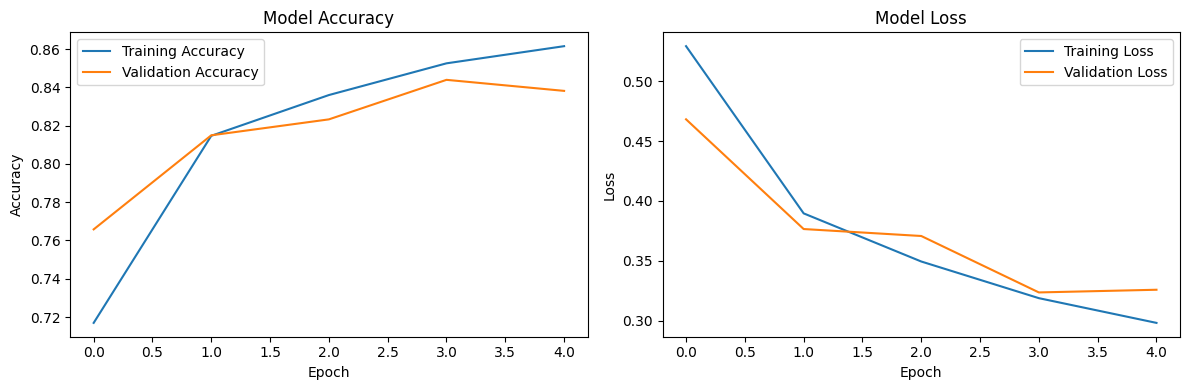

In [40]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history4.history['accuracy'], label='Training Accuracy')
plt.plot(history4.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history4.history['loss'], label='Training Loss')
plt.plot(history4.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


Confusion Matrix:
 [[3823  180]
 [1672 2129]]

Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.96      0.81      4003
           1       0.92      0.56      0.70      3801

    accuracy                           0.76      7804
   macro avg       0.81      0.76      0.75      7804
weighted avg       0.81      0.76      0.75      7804


ROC AUC Score: 0.8884010827711891


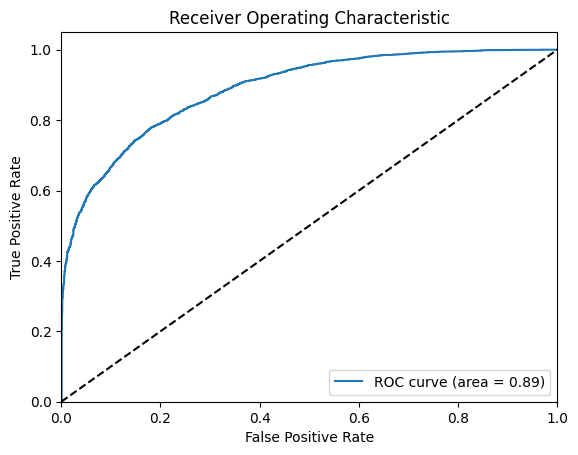

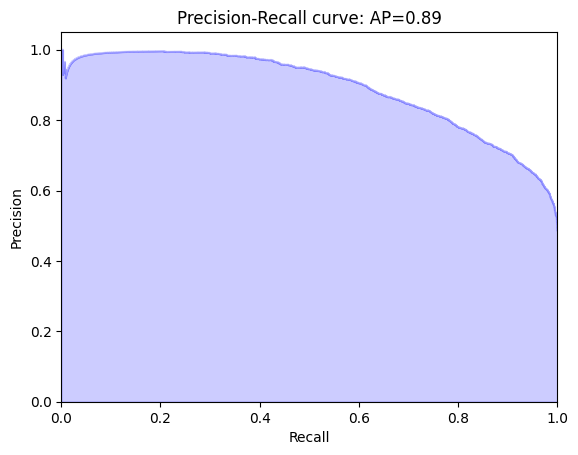

In [41]:

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_binary)
print("Confusion Matrix:\n", cm)

# Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred_binary))

# ROC AUC Score
roc_auc = roc_auc_score(y_test, y_pred)
print("\nROC AUC Score:", roc_auc)

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred)
average_precision = average_precision_score(y_test, y_pred)
plt.figure()
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
plt.show()
